## 数据分析咖哥十话

## 第2话 远近高低各不同：聚类实现RMF细分

**题解** 古有四库全书。所谓“四库”，即经、史、子、集四部，其下又细分为四十四类，这样做的目的是使浩如烟海的典籍易于查阅。对于数据分析师而言，分类分层，将复杂的用户统计数据和购买行为转化成清晰、明确、容易理解的结构，是精准获客和个性化运营的前提。

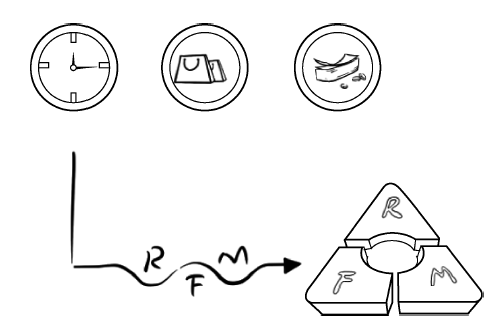

<center>RFM分析的流程</center>

**详细内容请参考拙作：《数据分析咖哥十话》** 人民邮电出版社2022年出版
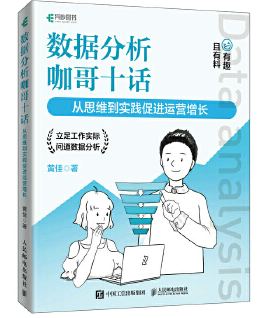
购书链接：https://item.jd.com/13335199.html

In [33]:
import numpy as np # 导入NumPy
import pandas as pd # 导入Pandas
import matplotlib.pyplot as plt # 导入Matplotlib 的pyplot 模块
import seaborn as sns # 导入Seaborn
plt.rcParams["font.family"]=['SimHei'] #用来设定字体样式
plt.rcParams['font.sans-serif']=['SimHei'] #用来设定无衬线字体样式
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
df_sales = pd.read_csv('电商历史订单.csv') # 载入数据集
df_sales.head() # 输出前几行数据

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市
0,536374,21258,6/1/2022 9:09,绿联usb分线器 一拖四,32,10.95,15100,北京
1,536376,22114,6/1/2022 9:32,加大男装T恤男大码胖子宽松卡,48,50.45,15291,上海
2,536376,21733,6/1/2022 9:32,唐装男夏季青年棉麻中国风加肥,64,86.55,15291,上海
3,536378,22386,6/1/2022 9:37,越南进口白心火龙果4个装,10,108.95,14688,北京
4,536378,85099C,6/1/2022 9:37,大连美早樱桃400g 果径约26mm,10,166.95,14688,北京


In [34]:
df_sales.describe() #df_sales 的统计信息

,数量,单价,用户码
count,87180.000000,87180.000000,87180.000000
mean,10.008167,3.604724,15338.447855
std,48.769817,133.475409,392.000551
min,-9360.000000,0.000000,14681.000000
25%,2.000000,1.250000,15022.000000
50%,4.000000,1.950000,15334.000000
75%,12.000000,3.750000,15674.000000
max,3114.000000,38970.000000,16019.000000


In [35]:
df_sales = df_sales.loc[df_sales['数量'] > 0] # 清洗掉“数量”小于0 的数据

In [36]:
df_sales['总价'] = df_sales['数量'] * df_sales['单价'] # 计算每单的总价
df_sales.head() # 输出前几行数据

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市,总价
0,536374,21258,6/1/2022 9:09,绿联usb分线器 一拖四,32,10.95,15100,北京,350.4
1,536376,22114,6/1/2022 9:32,加大男装T恤男大码胖子宽松卡,48,50.45,15291,上海,2421.6
2,536376,21733,6/1/2022 9:32,唐装男夏季青年棉麻中国风加肥,64,86.55,15291,上海,5539.2
3,536378,22386,6/1/2022 9:37,越南进口白心火龙果4个装,10,108.95,14688,北京,1089.5
4,536378,85099C,6/1/2022 9:37,大连美早樱桃400g 果径约26mm,10,166.95,14688,北京,1669.5


<Axes: title={'center': '月销售额'}, xlabel='年,月'>

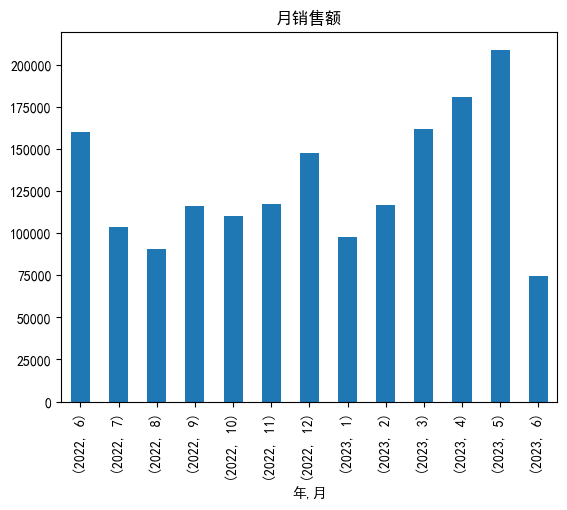

In [37]:
# 输出月销售额
df_sales['年'] = pd.DatetimeIndex(df_sales['消费日期']).year
df_sales['月'] = pd.DatetimeIndex(df_sales['消费日期']).month
df_sales.groupby(['年', '月'])['总价'].sum().plot(kind='bar', title = '月销售额')

<Axes: title={'center': '各地销售额'}, xlabel='城市'>

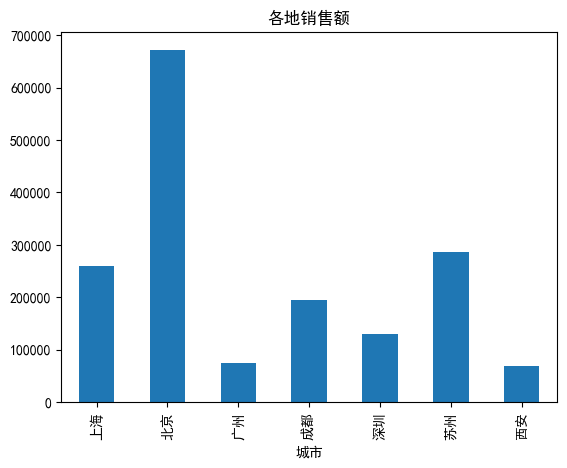

In [38]:
# 输出地区销售额
df_sales.groupby(['城市'])['总价'].sum().plot(kind='bar',title = '各地销售额')

In [39]:
df_user = pd.DataFrame(df_sales['用户码'].unique()) # 生成以“用户码”为主键的对象df_user
df_user.columns = ['用户码'] # 设定字段名
df_user = df_user.sort_values(by='用户码',ascending=True).reset_index(drop=True) # 按“用户码”排序
df_user # 输出df_user

,用户码
0,14681
1,14682
2,14684
3,14687
4,14688
...,...
975,16015
976,16016
977,16017
978,16018


In [40]:
df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期']) # 转化日期格式
df_recent_buy = df_sales.groupby('用户码'). 消费日期.max().reset_index() # 构建消费日期信息
df_recent_buy.columns = ['用户码','最近日期'] # 设定字段名
df_recent_buy['R值'] = (df_recent_buy['最近日期'].max() - df_recent_buy['最近日期']).dt.days # 计算最新日期距上次消费日期的天数
df_user = pd.merge(df_user, df_recent_buy[['用户码','R值']], on='用户码') # 把上次消费日期距最新日期的天数（R 值）合并至df_user 对象
df_user.head() # 输出前几行数据

,用户码,R值
0,14681,70
1,14682,187
2,14684,25
3,14687,106
4,14688,7


<Axes: title={'center': '新进度分布直方图'}, ylabel='Frequency'>

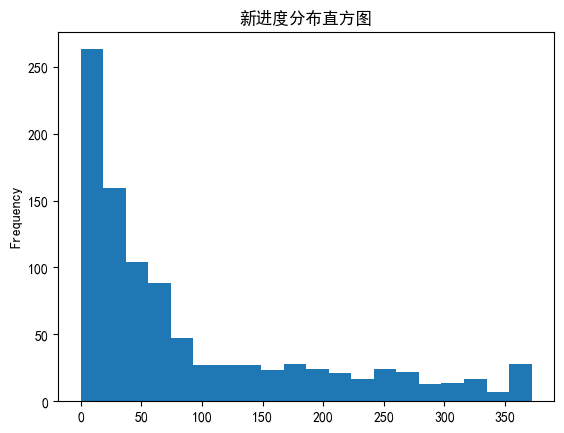

In [41]:
df_user['R值'].plot(kind='hist', bins=20, title = '新进度分布直方图') #R值直方图

In [42]:
from sklearn.cluster import KMeans # 导入KMeans 模块

In [43]:
def show_elbow(df): #定义手肘函数
    distance_list = [] #聚质心的距离（损失）
    K = range(1,9) #K值范围
    for k in K:
        kmeans = KMeans(n_clusters=k, max_iter=100) #创建KMeans模型
        kmeans = kmeans.fit(df) #拟合模型
        distance_list.append(kmeans.inertia_) #创建每个K值的损失
    plt.plot(K, distance_list, 'bx-') #绘图
    plt.xlabel('k') #X轴
    plt.ylabel('距离均方误差') #Y轴
    plt.title('k值手肘图') #标题

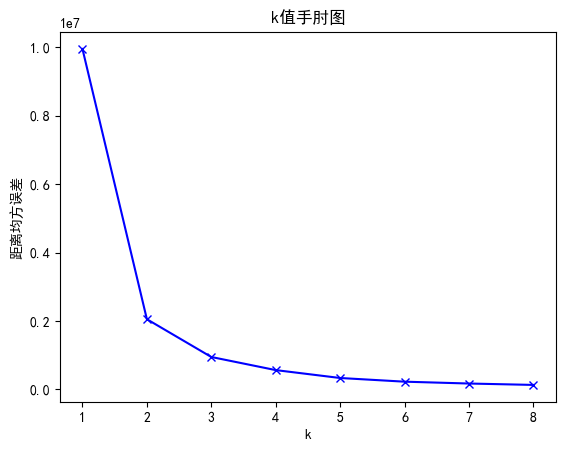

In [44]:
show_elbow(df_user[['R值']]) #显示R值聚类K值手肘图

In [45]:
kmeans = KMeans(n_clusters=3) # 设定K =3
kmeans.fit(df_user[['R值']]) # 拟合模型
df_user['R值层级'] = kmeans.predict(df_user[['R值']]) # 通过聚类模型求出R 值的层级
df_user.head() # 输出前几行数据

,用户码,R值,R值层级
0,14681,70,2
1,14682,187,0
2,14684,25,2
3,14687,106,0
4,14688,7,2


In [46]:
df_user.groupby('R值层级')['R值'].describe() #R 值层级分组统计信息

,count,mean,std,min,25%,50%,75%,max
R值层级,,,,,,,,
0,178.0,157.162921,37.340870,95.0,126.00,156.5,188.75,225.0
1,138.0,298.094203,45.436550,231.0,255.25,292.5,334.50,372.0
2,664.0,32.088855,25.141763,0.0,10.00,25.0,50.00,94.0


In [47]:
# 为聚类排序
def order_cluster(cluster_name, target_name,df,ascending=False):
    new_cluster_name = 'new_' + cluster_name # 新的聚类名称
    df_new = df.groupby(cluster_name)[target_name].mean().reset_index() # 按聚类结果分组，创建df_new对象
    df_new = df_new.sort_values(by=target_name,ascending=ascending).reset_index(drop=True) # 排序
    df_new['index'] = df_new.index # 创建索引字段
    df_new = pd.merge(df,df_new[[cluster_name,'index']], on=cluster_name) # 基于聚类名称把df_new 还原为df对象，并添加索引字段
    df_new = df_new.drop([cluster_name],axis=1) # 删除聚类名称
    df_new = df_new.rename(columns={"index":cluster_name}) # 将索引字段重命名为聚类名称字段
    return df_new # 返回排序后的df_new 对象

In [48]:
df_user = order_cluster('R值层级', 'R值', df_user, False) # 调用簇排序函数
df_user = df_user.sort_values(by='用户码',ascending=True).reset_index(drop=True) # 根据用户码排序
df_user.head() # 输出前几行数据

,用户码,R值,R值层级
0,14681,70,2
1,14682,187,1
2,14684,25,2
3,14687,106,1
4,14688,7,2


In [49]:
df_user.groupby('R值层级')['R值'].describe() #R 值层级分组统计信息

,count,mean,std,min,25%,50%,75%,max
R值层级,,,,,,,,
0,138.0,298.094203,45.436550,231.0,255.25,292.5,334.50,372.0
1,178.0,157.162921,37.340870,95.0,126.00,156.5,188.75,225.0
2,664.0,32.088855,25.141763,0.0,10.00,25.0,50.00,94.0


In [50]:
df_frequency = df_sales.groupby('用户码'). 消费日期.count().reset_index() # 计算每个用户的消费次数，构建df_frequency 对象
df_frequency.columns = ['用户码','F值'] # 设定字段名称
df_user = pd.merge(df_user, df_frequency, on='用户码') # 把消费频率整合至df_user 对象
df_user.head() # 输出前几行数据

,用户码,R值,R值层级,F值
0,14681,70,2,7
1,14682,187,1,2
2,14684,25,2,421
3,14687,106,1,15
4,14688,7,2,330


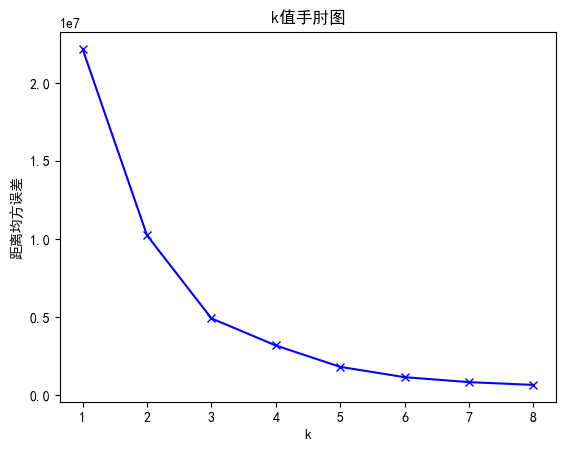

In [51]:
show_elbow(df_user[['F值']]) #显示F值聚类K值手肘图

In [52]:
kmeans = KMeans(n_clusters=4) #设定K=4
kmeans.fit(df_user[['F值']]) #拟合模型
df_user['F值层级'] = kmeans.predict(df_user[['F值']]) #通过聚类模型求出F值的层级
df_user = order_cluster('F值层级', 'F值',df_user,True) #调用簇排序函数
df_user.groupby('F值层级')['F值'].describe() #F值层级分组统计信息

,count,mean,std,min,25%,50%,75%,max
F值层级,,,,,,,,
0,755.0,35.660927,27.750336,1.0,12.0,28.0,53.00,106.0
1,180.0,177.005556,59.519819,108.0,128.0,157.5,213.25,330.0
2,40.0,483.475000,142.117140,335.0,385.0,446.5,525.75,937.0
3,5.0,1446.200000,547.794396,1090.0,1119.0,1141.0,1502.00,2379.0


In [53]:
df_user = df_user.sort_values(by='用户码',ascending=True).reset_index(drop=True) # 根据“用户码”排序
df_user.head()

,用户码,R值,R值层级,F值,F值层级
0,14681,70,2,7,0
1,14682,187,1,2,0
2,14684,25,2,421,2
3,14687,106,1,15,0
4,14688,7,2,330,1


In [54]:
df_revenue = df_sales.groupby('用户码'). 总价.sum().reset_index() # 根据消费金额构建df_revenue 对象
df_revenue.columns = ['用户码','M值'] # 设定字段名称
df_user = pd.merge(df_user, df_revenue, on='用户码') # 把消费金额整合至df_user 对象
df_user.head() # 输出前几行数据

,用户码,R值,R值层级,F值,F值层级,M值
0,14681,70,2,7,0,498.95
1,14682,187,1,2,0,52.00
2,14684,25,2,421,2,1236.28
3,14687,106,1,15,0,628.38
4,14688,7,2,330,1,18859.37


(array([667., 166.,  60.,  27.,  16.,   8.,   9.,   1.,   5.,   3.,   3.,
          1.,   1.,   2.,   0.,   2.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   1.,   0.,   0.,   1.]),
 array([6.2000000e+00, 1.2214340e+03, 2.4366680e+03, 3.6519020e+03,
        4.8671360e+03, 6.0823700e+03, 7.2976040e+03, 8.5128380e+03,
        9.7280720e+03, 1.0943306e+04, 1.2158540e+04, 1.3373774e+04,
        1.4589008e+04, 1.5804242e+04, 1.7019476e+04, 1.8234710e+04,
        1.9449944e+04, 2.0665178e+04, 2.1880412e+04, 2.3095646e+04,
        2.4310880e+04, 2.5526114e+04, 2.6741348e+04, 2.7956582e+04,
        2.9171816e+04, 3.0387050e+04, 3.1602284e+04, 3.2817518e+04,
        3.4032752e+04, 3.5247986e+04, 3.6463220e+04, 3.7678454e+04,
        3.8893688e+04, 4.0108922e+04, 4.1324156e+04, 4.2539390e+04,
        4.3754624e+04, 4.4969858e+04, 4.618509

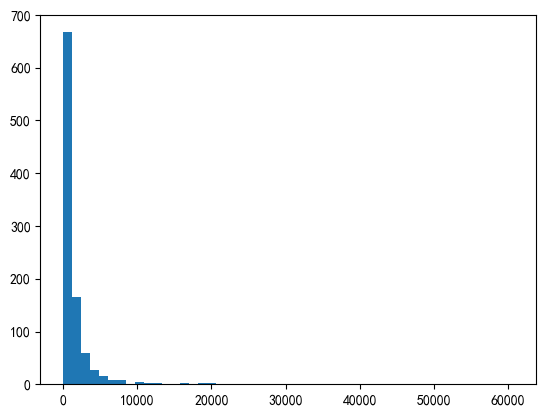

In [55]:
plt.hist(df_user['M值'],bins=50) #M 值直方图

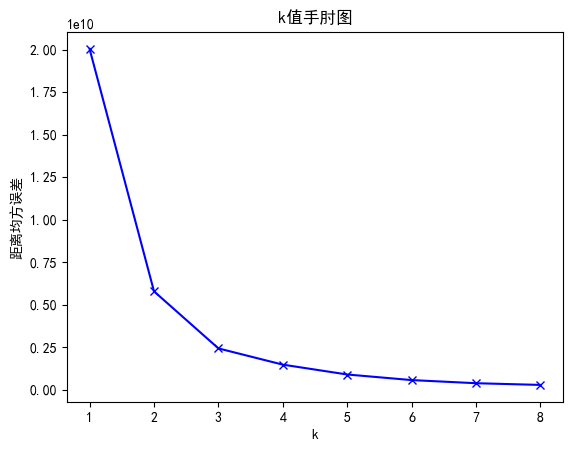

In [56]:
show_elbow(df_user[['M值']]) # 输出M 值聚类K 值手肘图

In [57]:
kmeans = KMeans(n_clusters=4) # 设定K =4
kmeans.fit(df_user[['M值']]) # 拟合模型
df_user['M值层级'] = kmeans.predict(df_user[['M值']]) # 通过聚类模型求出M 值的层级
df_user = order_cluster('M值层级', 'M值',df_user,True) # 调用簇排序函数
df_user.groupby('M值层级')['M值'].describe() #M 值层级分组统计信息

,count,mean,std,min,25%,50%,75%,max
M值层级,,,,,,,,
0,932.0,1008.116986,1071.174643,6.20,296.6675,597.79,1340.97,5528.48
1,41.0,10251.026829,4196.963275,5756.89,6802.7600,8347.20,12393.70,20261.10
2,4.0,38806.120000,4601.062891,33643.08,36258.7200,38523.55,41070.95,44534.30
3,3.0,57184.920000,3219.734238,54534.14,55393.4300,56252.72,58510.31,60767.90


In [58]:
df_user = df_user.sort_values(by='用户码',ascending=True).reset_index(drop=True) # 根据“用户码”排序
df_user.head() # 输出前几行数据

,用户码,R值,R值层级,F值,F值层级,M值,M值层级
0,14681,70,2,7,0,498.95,0
1,14682,187,1,2,0,52.00,0
2,14684,25,2,421,2,1236.28,0
3,14687,106,1,15,0,628.38,0
4,14688,7,2,330,1,18859.37,1


In [59]:
df_user['总分'] = df_user['R值层级'] + df_user['F值层级'] + df_user['M值层级'] # 求出每个用户RFM 总分
df_user # 输出df_user

,用户码,R值,R值层级,F值,F值层级,M值,M值层级,总分
0,14681,70,2,7,0,498.95,0,2
1,14682,187,1,2,0,52.00,0,1
2,14684,25,2,421,2,1236.28,0,4
3,14687,106,1,15,0,628.38,0,1
4,14688,7,2,330,1,18859.37,1,4
...,...,...,...,...,...,...,...,...
975,16015,3,2,182,1,705.39,0,3
976,16016,2,2,235,1,1508.76,0,3
977,16017,46,2,32,0,211.88,0,2
978,16018,38,2,28,0,408.90,0,2


In [60]:
# 这是不成功的方法
df_user.query("总分 < 2 & 总分 > 0")['总体价值'] = '低价值'
df_user.query("总分 < 4 & 总分 > 2")['总体价值'] = '中价值'
df_user.query("总分 < 6 & 总分 > 4")['总体价值'] = '高价值'
df_user # 输出df_user 对象

/var/folders/bm/3tpm902s0g58xsrv2t0v56dw0000gn/T/ipykernel_6705/3690960070.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user.query("总分 < 2 & 总分 > 0")['总体价值'] = '低价值'
/var/folders/bm/3tpm902s0g58xsrv2t0v56dw0000gn/T/ipykernel_6705/3690960070.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user.query("总分 < 4 & 总分 > 2")['总体价值'] = '中价值'
/var/folders/bm/3tpm902s0g58xsrv2t0v56dw0000gn/T/ipykernel_6705/3690960070.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

,用户码,R值,R值层级,F值,F值层级,M值,M值层级,总分
0,14681,70,2,7,0,498.95,0,2
1,14682,187,1,2,0,52.00,0,1
2,14684,25,2,421,2,1236.28,0,4
3,14687,106,1,15,0,628.38,0,1
4,14688,7,2,330,1,18859.37,1,4
...,...,...,...,...,...,...,...,...
975,16015,3,2,182,1,705.39,0,3
976,16016,2,2,235,1,1508.76,0,3
977,16017,46,2,32,0,211.88,0,2
978,16018,38,2,28,0,408.90,0,2


In [61]:
# 在df_user 对象中添加“总体价值”字段
df_user.loc[(df_user['总分']<=2) & (df_user['总分']>=0), '总体价值'] = '低价值'
df_user.loc[(df_user['总分']<=4) & (df_user['总分']>=3), '总体价值'] = '中价值'
df_user.loc[(df_user['总分']<=8) & (df_user['总分']>=5), '总体价值'] = '高价值'
df_user # 输出df_user 对象

,用户码,R值,R值层级,F值,F值层级,M值,M值层级,总分,总体价值
0,14681,70,2,7,0,498.95,0,2,低价值
1,14682,187,1,2,0,52.00,0,1,低价值
2,14684,25,2,421,2,1236.28,0,4,中价值
3,14687,106,1,15,0,628.38,0,1,低价值
4,14688,7,2,330,1,18859.37,1,4,中价值
...,...,...,...,...,...,...,...,...,...
975,16015,3,2,182,1,705.39,0,3,中价值
976,16016,2,2,235,1,1508.76,0,3,中价值
977,16017,46,2,32,0,211.88,0,2,低价值
978,16018,38,2,28,0,408.90,0,2,低价值


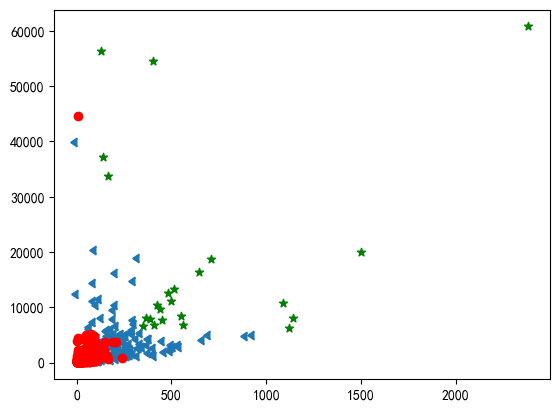

In [62]:
# 输出高、中、低价值用户的分布散点图（F 值与M 值）
plt.scatter(df_user.query("总体价值 == '高价值'")['F值'], # 五角星代表高价值用户
df_user.query("总体价值 == '高价值'")['M值'],c='g',marker='*')
plt.scatter(df_user.query("总体价值 == '中价值'")['F值'], # 圆点代表中价值用户
df_user.query("总体价值 == '中价值'")['M值'],marker=8)
plt.scatter(df_user.query("总体价值 == '低价值'")['F值'], # 三角形代表低价值用户
df_user.query("总体价值 == '低价值'")['M值'],c='r')

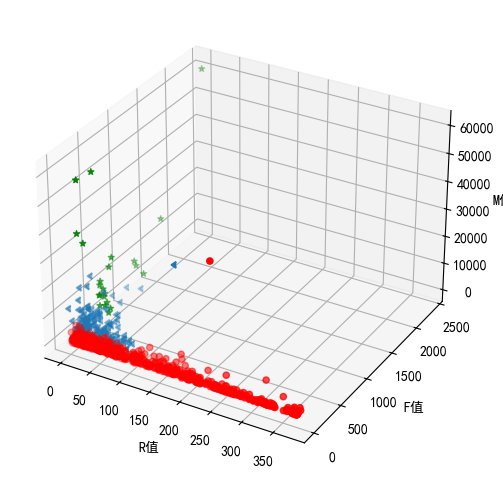

In [63]:
plt.figure(figsize=(6,6)) # 图片大小
ax = plt.subplot(111, projection='3d') # 坐标系
ax.scatter(df_user.query("总体价值 == '高价值'")['R值'], # 散点图
df_user.query("总体价值 == '高价值'")['F值'],
df_user.query("总体价值 == '高价值'")['M值'], c='g',marker='*')
ax.scatter(df_user.query("总体价值 == '中价值'")['R值'],
df_user.query("总体价值 == '中价值'")['F值'],
df_user.query("总体价值 == '中价值'")['M值'], marker=8)
ax.scatter(df_user.query("总体价值 == '低价值'")['R值'],
df_user.query("总体价值 == '低价值'")['F值'],
df_user.query("总体价值 == '低价值'")['M值'], c='r')
ax.set_xlabel('R值') # 坐标轴
ax.set_ylabel('F值') # 坐标轴
ax.set_zlabel('M值') # 坐标轴
plt.show() # 输出

总结到这里，马总突然发问：“咖哥，咱们快看看我这些用户中，哪些是最有价值的。我们要把他们列为VIP用户。我要为他们赠送专属礼包，邀请他们参与新一轮的推广活动，他们的朋友们一定也会成为新的VIP。”
咖哥说：“那很简单，就输出最高分值得的用户的姓名就好啦。”
说时迟，那是快，咖哥迅速的写了一行代码，输出了总分为8分的用户。

df_user.query("总分 == 8")
 
大家发现总分为8的用户只有一个人，这个用户的R、F、M三个值都是最高层级，显然是VIP中的VIP。
马总赶忙从他的手机App中查询该编号为15311号用户的具体信息，还真给查着了。
 
罗小雪居然是VIP用户！
不料，查询的结果令大家大吃一惊，赫然是看到了小雪的名字！
“重名了吧！”小雪哈哈笑到。“我希望我男朋友在这个列表里面倒是真的呢。”

**详细内容请参考拙作：《数据分析咖哥十话》** 人民邮电出版社2022年出版